# Trực quan hóa dữ liệu

In [ ]:
!pip install -U openai-whisper


In [ ]:
import whisper

model = whisper.load_model("small")

result = model.transcribe(
    "/content/an2.mp3",
    language="vi"
)

print("Nội dung giọng nói:")
print(result["text"])


100%|████████████████████████████████████████| 461M/461M [00:03<00:00, 121MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Nội dung giọng nói:
 Tín hiệu chúng ta luôn cần phải xoay cắt tín hiệu với nhau chẳng hát như vấn đề của tín hiệu radar radar sẽ bắt tín hiệu để tìm một tiêu tín hiệu này ra nó sẽ đập vào một tiêu như máy bay và phát ra trở lại radar


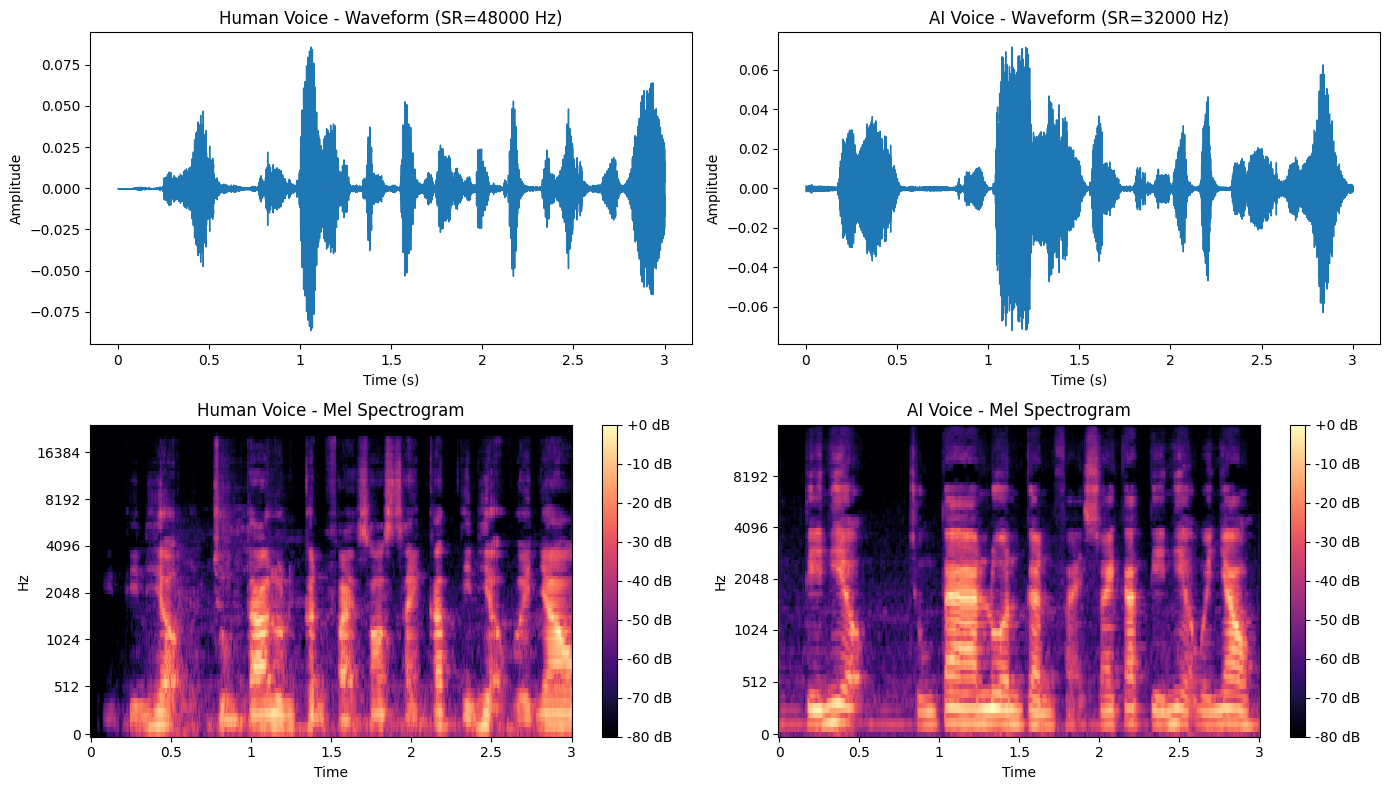

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

N_MELS = 80
HOP = 256
N_FFT = 1024
DURATION = 3.0

def load_audio_raw(path, duration=DURATION):
    audio, sr = librosa.load(
        path,
        sr=None,
        mono=True,
        duration=duration
    )
    return audio, sr

def get_mel(audio, sr):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP,
        n_mels=N_MELS,
        fmax=sr // 2
    )
    return librosa.power_to_db(mel, ref=np.max)

def visualize_ai_vs_human(human_path, ai_path):
    human_audio, human_sr = load_audio_raw(human_path)
    ai_audio, ai_sr = load_audio_raw(ai_path)

    human_mel = get_mel(human_audio, human_sr)
    ai_mel = get_mel(ai_audio, ai_sr)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    librosa.display.waveshow(human_audio, sr=human_sr)
    plt.title(f"Human Voice - Waveform (SR={human_sr} Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(ai_audio, sr=ai_sr)
    plt.title(f"AI Voice - Waveform (SR={ai_sr} Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 2, 3)
    librosa.display.specshow(
        human_mel,
        sr=human_sr,
        hop_length=HOP,
        x_axis="time",
        y_axis="mel"
    )
    plt.title("Human Voice - Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(2, 2, 4)
    librosa.display.specshow(
        ai_mel,
        sr=ai_sr,
        hop_length=HOP,
        x_axis="time",
        y_axis="mel"
    )
    plt.title("AI Voice - Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

visualize_ai_vs_human(
    human_path="/content/an2.mp3",
    ai_path="/content/an2_ai.mp3"
)


# Tiền xử lý hoàn chỉnh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub librosa soundfile webrtcvad

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm

SR = 16000
TARGET_RMS = 0.08
CROP_SEC = 2.5
MIN_SEC = 1.5
NUM_CROPS = 2
ENERGY_TH = 1e-4

# LOAD dữ liệu
def load_audio(path, sr=SR):
    audio, _ = librosa.load(path, sr=sr, mono=True)
    return audio.astype(np.float32), sr

# NORMALIZE (SOFT)
def normalize_soft(audio, target_rms=TARGET_RMS):
    rms = np.sqrt(np.mean(audio ** 2) + 1e-9)

    # tránh normalize quá mạnh
    scale = min(target_rms / rms, 3.0)
    return audio * scale

# RANDOM CROP
def random_crop_energy(audio, sr,
                       crop_sec=CROP_SEC,
                       min_sec=MIN_SEC,
                       num_crops=NUM_CROPS):

    crops = []
    crop_len = int(sr * crop_sec)
    min_len = int(sr * min_sec)

    if len(audio) < min_len:
        return crops

    for _ in range(num_crops):
        if len(audio) <= crop_len:
            seg = audio
        else:
            start = np.random.randint(0, len(audio) - crop_len)
            seg = audio[start:start + crop_len]

        if np.mean(seg ** 2) > ENERGY_TH:
            crops.append(seg)

    return crops

def process_file(input_path, output_folder, prefix):
    try:
        audio, sr = load_audio(input_path)

        audio = normalize_soft(audio)

        segments = random_crop_energy(audio, sr)

        if len(segments) == 0:
            return False

        base = os.path.splitext(os.path.basename(input_path))[0]
        for i, seg in enumerate(segments):
            out_path = os.path.join(
                output_folder, f"{prefix}_{base}_{i}.wav"
            )

            sf.write(out_path, seg, sr, subtype="FLOAT")

        return True

    except Exception as e:
        print("Error:", input_path, e)
        return False

def process_folder(input_folder, output_folder, prefix):
    os.makedirs(output_folder, exist_ok=True)

    files = [
        f for f in os.listdir(input_folder)
        if f.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.aac'))
    ]

    print(f"{input_folder} | {len(files)} files")

    for f in tqdm(files):
        process_file(
            os.path.join(input_folder, f),
            output_folder,
            prefix
        )

# RUN
process_folder(
    "/content/drive/MyDrive/ChuyenDe/data/giọng người và data kaggle",
    "audio_pre_aasist_v2/human",
    "human"
)

process_folder(
    "/content/drive/MyDrive/ChuyenDe/data/13 12 clone voice",
    "audio_pre_aasist_v2/ai",
    "ai"
)

process_folder(
    "/content/drive/MyDrive/ChuyenDe/data/data_AIYT",
    "audio_pre_aasist_v2/ai",
    "ai"
)

process_folder(
    "/content/drive/MyDrive/ChuyenDe/data/ai clone voice",
    "audio_pre_aasist_v2/ai",
    "ai"
)

print("DONE PREPROCESSING")


/content/drive/MyDrive/ChuyenDe/data/giọng người và data kaggle | 756 files


100%|██████████| 756/756 [02:23<00:00,  5.27it/s]


/content/drive/MyDrive/ChuyenDe/data/13 12 clone voice | 43 files


100%|██████████| 43/43 [00:39<00:00,  1.09it/s]


/content/drive/MyDrive/ChuyenDe/data/data_AIYT | 27 files


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


/content/drive/MyDrive/ChuyenDe/data/ai clone voice | 77 files


100%|██████████| 77/77 [01:04<00:00,  1.20it/s]

DONE PREPROCESSING


# Trực quan TXL

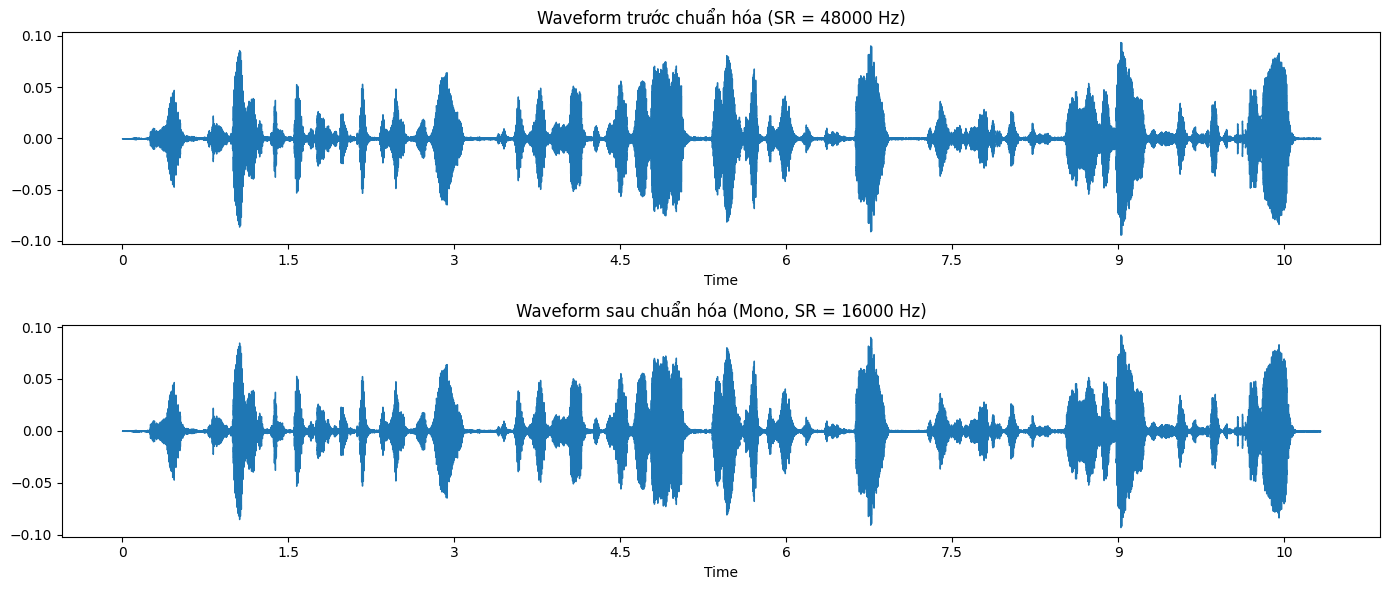

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

path = "/content/an2.mp3"

audio_raw, sr_raw = librosa.load(path, sr=None, mono=False)

if audio_raw.ndim > 1:
    audio_raw_plot = audio_raw[0]
else:
    audio_raw_plot = audio_raw

audio_norm, sr_norm = librosa.load(path, sr=16000, mono=True)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio_raw_plot, sr=sr_raw)
plt.title(f"Waveform trước chuẩn hóa (SR = {sr_raw} Hz)")

plt.subplot(2, 1, 2)
librosa.display.waveshow(audio_norm, sr=sr_norm)
plt.title("Waveform sau chuẩn hóa (Mono, SR = 16000 Hz)")

plt.tight_layout()
plt.show()


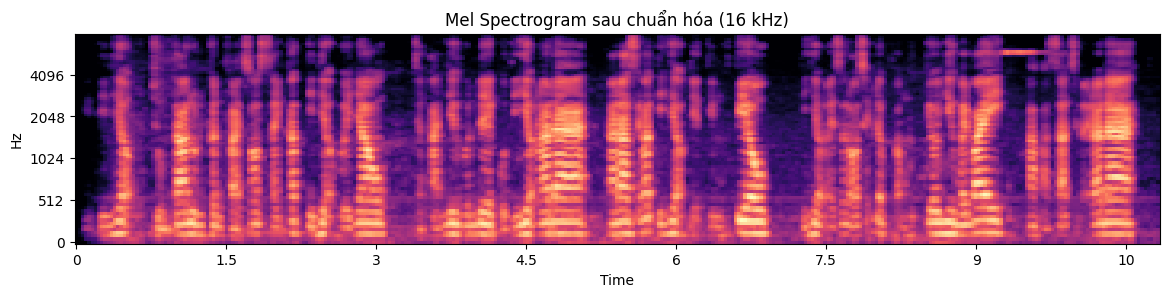

In [ ]:
MEL SPECTROGRAM
mel_raw = librosa.feature.melspectrogram(
    y=audio_raw_plot, sr=sr_raw, n_mels=80
)
mel_norm = librosa.feature.melspectrogram(
    y=audio_norm, sr=16000, n_mels=80
)

mel_raw_db = librosa.power_to_db(mel_raw, ref=np.max)
mel_norm_db = librosa.power_to_db(mel_norm, ref=np.max)

plt.figure(figsize=(14, 6))



plt.subplot(2, 1, 2)
librosa.display.specshow(mel_norm_db, sr=16000, x_axis="time", y_axis="mel")
plt.title("Mel Spectrogram sau chuẩn hóa (16 kHz)")


plt.show()


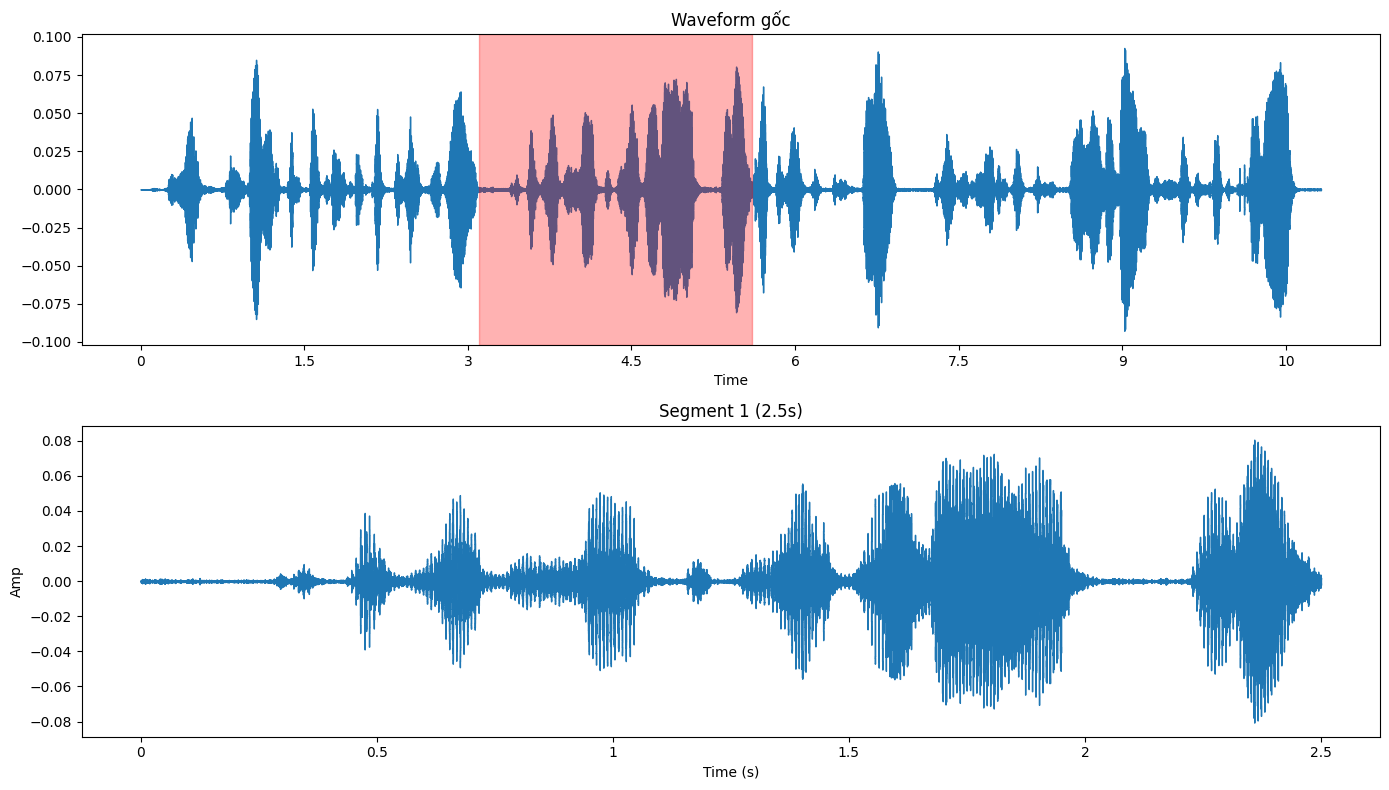

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

SR = 16000
CROP_SEC = 2.5
MIN_SEC = 1.5
NUM_CROPS = 2
ENERGY_TH = 1e-4
PATH = "/content/an2.mp3"

audio, sr = librosa.load(PATH, sr=SR, mono=True)
duration = len(audio) / sr

def random_crop_energy(audio, sr):
    crops = []
    positions = []

    crop_len = int(sr * CROP_SEC)
    min_len = int(sr * MIN_SEC)

    if len(audio) < min_len:
        return crops, positions

    for _ in range(NUM_CROPS):
        start = np.random.randint(0, max(1, len(audio) - crop_len))
        seg = audio[start:start + crop_len]

        if np.mean(seg ** 2) > ENERGY_TH:
            crops.append(seg)
            positions.append((start / sr, (start + len(seg)) / sr))

    return crops, positions

segments, positions = random_crop_energy(audio, sr)

plt.figure(figsize=(14, 8))

plt.subplot(len(segments) + 1, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform gốc")

for (s, e) in positions:
    plt.axvspan(s, e, color="red", alpha=0.3)

for i, seg in enumerate(segments):
    plt.subplot(len(segments) + 1, 1, i + 2)
    librosa.display.waveshow(seg, sr=sr)
    plt.title(f"Segment {i+1} ({len(seg)/sr:.1f}s)")
    plt.ylabel("Amp")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


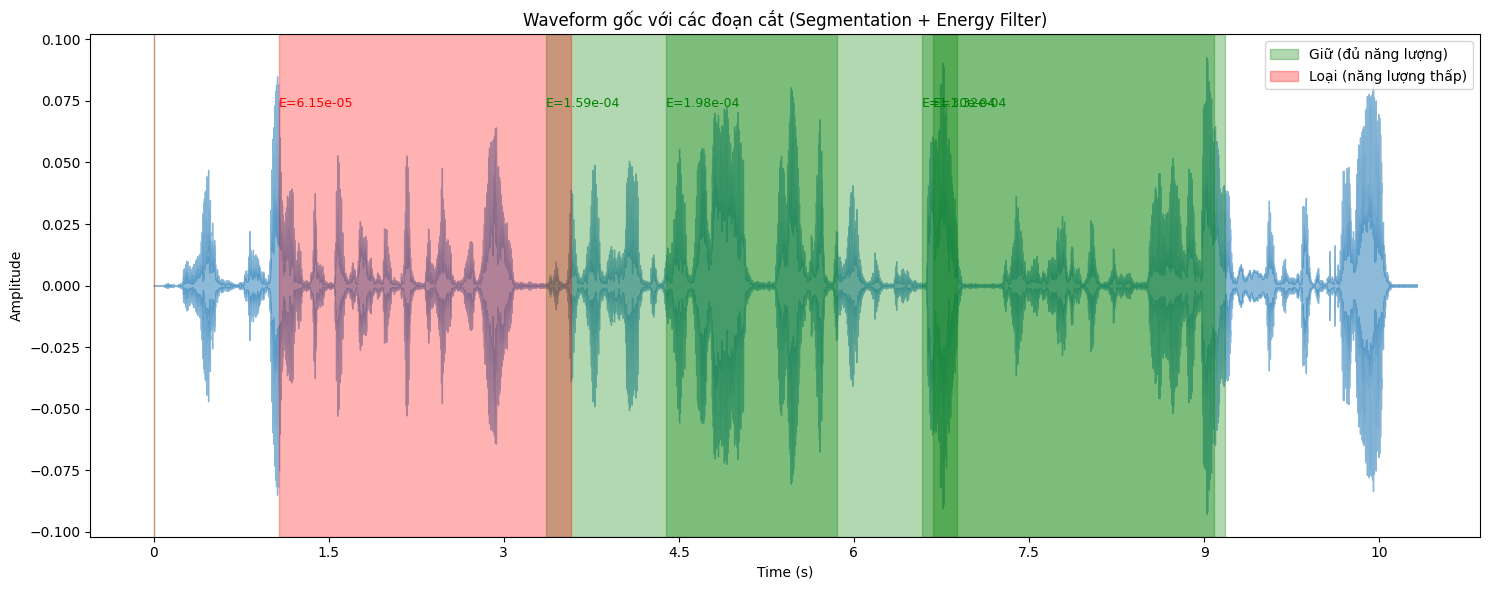

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

SR = 16000
CROP_SEC = 2.5
NUM_CROPS = 5
ENERGY_TH = 1e-4
PATH = "/content/an2.mp3"

audio, sr = librosa.load(PATH, sr=SR, mono=True)

def rms_energy(x):
    return np.mean(x ** 2)

crop_len = int(SR * CROP_SEC)

segments = []
positions = []

for _ in range(NUM_CROPS):
    start = np.random.randint(0, len(audio) - crop_len)
    seg = audio[start:start + crop_len]
    energy = rms_energy(seg)
    segments.append((seg, energy))
    positions.append(start)

plt.figure(figsize=(15, 6))
librosa.display.waveshow(audio, sr=SR, alpha=0.5)
plt.title("Waveform gốc với các đoạn cắt (Segmentation + Energy Filter)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

for (seg, energy), start in zip(segments, positions):
    start_t = start / SR
    end_t = (start + crop_len) / SR

    if energy > ENERGY_TH:
        color = "green"
        label = "Giữ (đủ năng lượng)"
    else:
        color = "red"
        label = "Loại (năng lượng thấp)"

    plt.axvspan(start_t, end_t, color=color, alpha=0.3)
    plt.text(start_t, 0.8*np.max(audio),
             f"E={energy:.2e}",
             color=color, fontsize=9)

# chú thích
plt.axvspan(0, 0, color="green", alpha=0.3, label="Giữ (đủ năng lượng)")
plt.axvspan(0, 0, color="red", alpha=0.3, label="Loại (năng lượng thấp)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


# Mô hình Conformer (CNN + Transformer)

In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import soundfile as sf

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256

MAX_LEN = 160
BATCH = 16
EPOCHS = 30
LR = 1e-4
DROPOUT = 0.3

PATIENCE = 6
MIN_EPOCH = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

class VoiceDataset(Dataset):
    def __init__(self, root, augment=False):
        self.items = []
        self.augment = augment

        for label, cls in enumerate(["human", "ai"]):
            folder = os.path.join(root, cls)
            for f in os.listdir(folder):
                if f.endswith(".wav"):
                    self.items.append((os.path.join(folder, f), label))

        random.shuffle(self.items)

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR,
            n_fft=N_FFT,
            hop_length=HOP,
            n_mels=N_MELS,
            power=2.0
        )
        self.db = torchaudio.transforms.AmplitudeToDB(stype="power")

    def __len__(self):
        return len(self.items)

    def pad_or_crop(self, x):
        if x.shape[1] < MAX_LEN:
            return F.pad(x, (0, MAX_LEN - x.shape[1]))
        return x[:, :MAX_LEN]

    def __getitem__(self, idx):
        path, label = self.items[idx]

        wav, sr = sf.read(path)
        if wav.ndim > 1:
            wav = wav.mean(axis=1)

        wav = torch.tensor(wav, dtype=torch.float32)

        if self.augment and label == 0 and random.random() < 0.2:
            wav += torch.randn_like(wav) * 0.001

        mel = self.db(self.mel(wav))
        mel = self.pad_or_crop(mel)

        return mel, torch.tensor(label, dtype=torch.float32)

class ConvSubsampling(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        b, c, f, t = x.shape
        x = x.view(b, c * f, t)
        return x.transpose(1, 2)

ENC_DIM = 64 * (N_MELS // 4)

class ConformerBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()

        self.ff1 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(DROPOUT),
            nn.Linear(dim * 4, dim),
        )

        self.attn = nn.MultiheadAttention(
            dim, heads, dropout=DROPOUT, batch_first=True
        )
        self.norm_attn = nn.LayerNorm(dim)

        self.conv = nn.Sequential(
            nn.Conv1d(dim, dim, 3, padding=1, groups=dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Conv1d(dim, dim, 1),
        )
        self.norm_conv = nn.LayerNorm(dim)

        self.ff2 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(DROPOUT),
            nn.Linear(dim * 4, dim),
        )

        self.norm_out = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + 0.5 * self.ff1(x)

        attn_out, _ = self.attn(x, x, x)
        x = self.norm_attn(x + attn_out)

        conv_out = self.conv(x.transpose(1, 2)).transpose(1, 2)
        x = self.norm_conv(x + conv_out)

        x = x + 0.5 * self.ff2(x)
        return self.norm_out(x)

class AttentivePooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.att = nn.Linear(dim, 1)

    def forward(self, x):
        w = torch.softmax(self.att(x), dim=1)
        return (x * w).sum(dim=1)

class AntiDeepfakeConformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.subsample = ConvSubsampling()

        self.encoder = nn.Sequential(
            ConformerBlock(ENC_DIM),
            ConformerBlock(ENC_DIM),
            ConformerBlock(ENC_DIM),
        )

        self.pool = AttentivePooling(ENC_DIM)

        self.fc = nn.Sequential(
            nn.Linear(ENC_DIM, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.subsample(x)
        x = self.encoder(x)
        x = self.pool(x)
        return self.fc(x).squeeze(1)

def compute_eer(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.abs(fnr - fpr))]

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()

    probs, gts, losses = [], [], []

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        with torch.set_grad_enabled(train):
            out = model(x)
            loss = loss_fn(out, y)

            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

        probs.extend(torch.sigmoid(out).detach().cpu().numpy())
        gts.extend(y.cpu().numpy())
        losses.append(loss.item())

    auc = roc_auc_score(gts, probs)
    eer = compute_eer(gts, probs)
    acc = accuracy_score(gts, np.array(probs) > 0.5)

    return np.mean(losses), acc, auc, eer

# Thư mục dữ liệu đã tiền xử lý
root = "audio_pre_aasist_v2"

full_ds = VoiceDataset(root, augment=False)
n_val = int(0.1 * len(full_ds))
tr_ds, va_ds = torch.utils.data.random_split(
    full_ds, [len(full_ds) - n_val, n_val]
)

tr_ds.dataset.augment = True
va_ds.dataset.augment = False

tr_loader = DataLoader(tr_ds, BATCH, shuffle=True)
va_loader = DataLoader(va_ds, BATCH)

model = AntiDeepfakeConformer().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=1
)

best_eer = 1.0
wait = 0

for ep in range(1, EPOCHS + 1):
    print(f"\nEpoch {ep}/{EPOCHS}")

    tr_l, tr_a, tr_auc, _ = run_epoch(model, tr_loader, opt)
    va_l, va_a, va_auc, va_eer = run_epoch(model, va_loader)

    print(
        f"Train AUC {tr_auc:.3f} | "
        f"Val AUC {va_auc:.3f} | "
        f"EER {va_eer:.3f}"
    )

    scheduler.step(va_eer)

    if va_eer < best_eer:
        best_eer = va_eer
        wait = 0
        torch.save(model.state_dict(), "anti_ai_conformer_best.pt")
        print(f"Saved best model | EER={va_eer:.4f}")
    else:
        wait += 1
        if ep >= MIN_EPOCH and wait >= PATIENCE:
            print("Early stopping")
            break

print(f"\nTRAIN DONE | BEST EER = {best_eer:.4f}")



Epoch 1/30


Train AUC 0.788 | Val AUC 0.920 | EER 0.114
Saved best model | EER=0.1141

Epoch 2/30


Train AUC 0.917 | Val AUC 0.963 | EER 0.101
Saved best model | EER=0.1007

Epoch 3/30


Train AUC 0.930 | Val AUC 0.945 | EER 0.128

Epoch 4/30


Train AUC 0.896 | Val AUC 0.225 | EER 0.664

Epoch 5/30


Train AUC 0.834 | Val AUC 0.874 | EER 0.228

Epoch 6/30


Train AUC 0.851 | Val AUC 0.947 | EER 0.161

Epoch 7/30


Train AUC 0.879 | Val AUC 0.939 | EER 0.148

Epoch 8/30


Train AUC 0.931 | Val AUC 0.942 | EER 0.121
Early stopping

TRAIN DONE | BEST EER = 0.1007


# Predict Conformer

In [ ]:
import torch
import torchaudio
import numpy as np
import soundfile as sf
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AntiDeepfakeConformer().to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/ChuyenDe/model/Conformer/anti_ai_conformer_best.pt", map_location=DEVICE))
model.eval()
SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256
MAX_LEN = 160

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT,
    hop_length=HOP,
    n_mels=N_MELS,
    power=2.0
)

db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
def normalize_soft(audio, target_rms=0.08):
    rms = np.sqrt(np.mean(audio ** 2) + 1e-9)
    scale = min(target_rms / rms, 3.0)
    return audio * scale
def split_crops(audio, sr=SR, crop_sec=2.5, num_crops=5):
    crop_len = int(sr * crop_sec)

    if len(audio) <= crop_len:
        return [audio]

    step = max((len(audio) - crop_len) // (num_crops - 1), 1)

    crops = []
    for i in range(num_crops):
        start = i * step
        seg = audio[start:start + crop_len]
        if len(seg) == crop_len:
            crops.append(seg)

    return crops
def predict_file(path):
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)

    wav = normalize_soft(wav)

    crops = split_crops(wav)

    probs = []

    with torch.no_grad():
        for seg in crops:
            seg = torch.tensor(seg, dtype=torch.float32)

            mel = mel_transform(seg)
            mel = db_transform(mel)

            if mel.shape[1] < MAX_LEN:
                mel = F.pad(mel, (0, MAX_LEN - mel.shape[1]))
            else:
                mel = mel[:, :MAX_LEN]

            mel = mel.unsqueeze(0).to(DEVICE)

            logit = model(mel)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    final_prob = float(np.mean(probs))

    label = "AI CLONE" if final_prob >= 0.5 else "HUMAN"

    return {
        "file": path,
        "prob_ai": final_prob,
        "prediction": label,
        "num_crops": len(probs)
    }


In [ ]:
result = predict_file("/content/AI.mp3")

print("File:", result["file"])
print("AI probability:", round(result["prob_ai"], 4))
print("Prediction:", result["prediction"])
print("Num crops:", result["num_crops"])


📄 File: /content/AI.mp3
🤖 AI probability: 0.9549
🧠 Prediction: AI CLONE
🎧 Num crops: 5


# Mô hình AASIST

In [ ]:
import os, random
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256
MAX_LEN = 256

BATCH = 12
EPOCHS = 40
LR = 3e-4

PATIENCE = 6
MIN_EPOCH = 5
DROPOUT = 0.3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

class VoiceDataset(Dataset):
    def __init__(self, root, augment=False):
        self.items = []
        self.augment = augment

        for lab, cls in enumerate(["human", "ai"]):
            folder = os.path.join(root, cls)
            for f in os.listdir(folder):
                if f.endswith(".wav"):
                    self.items.append((os.path.join(folder, f), lab))

        random.shuffle(self.items)

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR,
            n_fft=N_FFT,
            hop_length=HOP,
            n_mels=N_MELS
        )

        self.freq_mask = torchaudio.transforms.FrequencyMasking(8)
        self.time_mask = torchaudio.transforms.TimeMasking(12)

    def __len__(self):
        return len(self.items)

    def pad_or_crop(self, m):
        if m.shape[1] < MAX_LEN:
            return F.pad(m, (0, MAX_LEN - m.shape[1]))
        return m[:, :MAX_LEN]

    def __getitem__(self, idx):
        path, label = self.items[idx]
        audio, _ = librosa.load(path, sr=SR, mono=True)

        mel = torch.log(self.mel(torch.tensor(audio)) + 1e-9)

        if self.augment:
            if random.random() < 0.5:
                mel = self.freq_mask(mel)
            if random.random() < 0.5:
                mel = self.time_mask(mel)

        mel = self.pad_or_crop(mel)
        return mel, torch.tensor(label, dtype=torch.float32)

class AASISTFrontend(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x.unsqueeze(1))

class SpectralAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)

    def forward(self, x):
        # B×C×F×T → B×F×C
        x = x.mean(dim=-1).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)


class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)

    def forward(self, x):
        # B×C×F×T → B×T×C
        x = x.mean(dim=2).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)


class AASIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = AASISTFrontend()
        self.spec_attn = SpectralAttention(128)
        self.temp_attn = TemporalAttention(128)

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        spec = self.spec_attn(x)
        temp = self.temp_attn(x)
        feat = torch.cat([spec, temp], dim=1)
        return self.fc(feat).squeeze(1)

def compute_eer(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.abs(fnr - fpr))]

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()

    probs, gts, losses = [], [], []

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        with torch.set_grad_enabled(train):
            out = model(x)
            loss = loss_fn(out, y)

            if train:
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                opt.step()

        probs.extend(torch.sigmoid(out).detach().cpu().numpy())
        gts.extend(y.cpu().numpy())
        losses.append(loss.item())

    auc = roc_auc_score(gts, probs)
    eer = compute_eer(gts, probs)
    acc = accuracy_score(gts, np.array(probs) > 0.5)

    return np.mean(losses), acc, auc, eer

# Folder data đã txl
root = "/content/audio_pre_aasist_v2"

full_ds = VoiceDataset(root, augment=False)

# balanced loss
labels = [lab for _, lab in full_ds.items]
pos_weight = torch.tensor(
    len(labels) / (sum(labels) + 1e-6),
    device=DEVICE
)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_val = int(0.1 * len(full_ds))
tr_ds, va_ds = random_split(full_ds, [len(full_ds)-n_val, n_val])

tr_ds.dataset.augment = True
va_ds.dataset.augment = False

tr_loader = DataLoader(tr_ds, BATCH, shuffle=True)
va_loader = DataLoader(va_ds, BATCH)

model = AASIST().to(DEVICE)

opt = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=2
)

best_eer = 1.0
wait = 0

for ep in range(1, EPOCHS + 1):
    print(f"\nEpoch {ep}/{EPOCHS}")

    tr_l, tr_a, tr_auc, _ = run_epoch(model, tr_loader, opt)
    va_l, va_a, va_auc, va_eer = run_epoch(model, va_loader)

    print(
        f"Train AUC {tr_auc:.3f} | "
        f"Val AUC {va_auc:.3f} | "
        f"EER {va_eer:.3f}"
    )

    scheduler.step(va_eer)

    if va_eer < best_eer:
        best_eer = va_eer
        wait = 0
        torch.save(model.state_dict(), "aasist_best.pt")
        print(f"✔ Saved best model | EER={va_eer:.4f}")
    else:
        wait += 1
        if ep >= MIN_EPOCH and wait >= PATIENCE:
            print("⏹ Early stopping")
            break

print(f"\nTRAIN DONE | BEST EER = {best_eer:.4f}")



Epoch 1/40


Train AUC 0.778 | Val AUC 0.755 | EER 0.345
✔ Saved best model | EER=0.3446

Epoch 2/40


Train AUC 0.800 | Val AUC 0.776 | EER 0.304
✔ Saved best model | EER=0.3041

Epoch 3/40


Train AUC 0.833 | Val AUC 0.862 | EER 0.223
✔ Saved best model | EER=0.2230

Epoch 4/40


Train AUC 0.846 | Val AUC 0.880 | EER 0.243

Epoch 5/40


Train AUC 0.879 | Val AUC 0.913 | EER 0.209
✔ Saved best model | EER=0.2095

Epoch 6/40


Train AUC 0.916 | Val AUC 0.980 | EER 0.068
✔ Saved best model | EER=0.0676

Epoch 7/40


Train AUC 0.968 | Val AUC 0.994 | EER 0.034
✔ Saved best model | EER=0.0338

Epoch 8/40


Train AUC 0.976 | Val AUC 0.994 | EER 0.027
✔ Saved best model | EER=0.0270

Epoch 9/40


Train AUC 0.974 | Val AUC 0.995 | EER 0.014
✔ Saved best model | EER=0.0135

Epoch 10/40


Train AUC 0.980 | Val AUC 0.995 | EER 0.027

Epoch 11/40


Train AUC 0.990 | Val AUC 0.996 | EER 0.020

Epoch 12/40


Train AUC 0.988 | Val AUC 0.995 | EER 0.041

Epoch 13/40


Train AUC 0.993 | Val AUC 0.999 | EER 0.034

Epoch 14/40


Train AUC 0.992 | Val AUC 0.998 | EER 0.047

Epoch 15/40


Train AUC 0.994 | Val AUC 0.998 | EER 0.014
⏹ Early stopping

✅ TRAIN DONE | BEST EER = 0.0135


# Predict AASIST

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256
MAX_LEN = 256

CROP_SEC = 2.5
NUM_CROPS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class AASISTFrontend(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x.unsqueeze(1))


class SpectralAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)

    def forward(self, x):
        # B×C×F×T → B×F×C
        x = x.mean(dim=-1).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)


class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)

    def forward(self, x):
        # B×C×F×T → B×T×C
        x = x.mean(dim=2).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)


class AASIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = AASISTFrontend()
        self.spec_attn = SpectralAttention(128)
        self.temp_attn = TemporalAttention(128)

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        spec = self.spec_attn(x)
        temp = self.temp_attn(x)
        feat = torch.cat([spec, temp], dim=1)
        return self.fc(feat).squeeze(1)

model = AASIST().to(DEVICE)
state = torch.load("aasist_best.pt", map_location=DEVICE)
model.load_state_dict(state)
model.eval()
mel_extractor = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT,
    hop_length=HOP,
    n_mels=N_MELS
)
def predict_file(path, num_crops=NUM_CROPS):
    audio, _ = librosa.load(path, sr=SR, mono=True)
    audio = audio.astype(np.float32)

    crop_len = int(SR * CROP_SEC)
    scores = []

    for _ in range(num_crops):
        if len(audio) <= crop_len:
            seg = audio
        else:
            start = np.random.randint(0, len(audio) - crop_len)
            seg = audio[start:start + crop_len]

        mel = torch.log(
            mel_extractor(torch.tensor(seg)) + 1e-9
        )

        if mel.shape[1] < MAX_LEN:
            mel = F.pad(mel, (0, MAX_LEN - mel.shape[1]))
        else:
            mel = mel[:, :MAX_LEN]

        mel = mel.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logit = model(mel)
            prob = torch.sigmoid(logit).item()
            scores.append(prob)

    return float(np.mean(scores))
def classify(path, threshold=0.5):
    score = predict_file(path)

    label = "AI (spoof)" if score >= threshold else "HUMAN (real)"

    print("================================")
    print(f"File      : {os.path.basename(path)}")
    print(f"Score     : {score:.4f}")
    print(f"Predict   : {label}")
    print("================================")

    return score, label
test_audio = "/content/an1.mp3"
classify(test_audio)


📂 File      : 120.mp3
🔢 Score     : 0.7625
🎯 Predict   : AI (spoof)


(0.7625261306762695, 'AI (spoof)')

# Đánh giá tổng quan

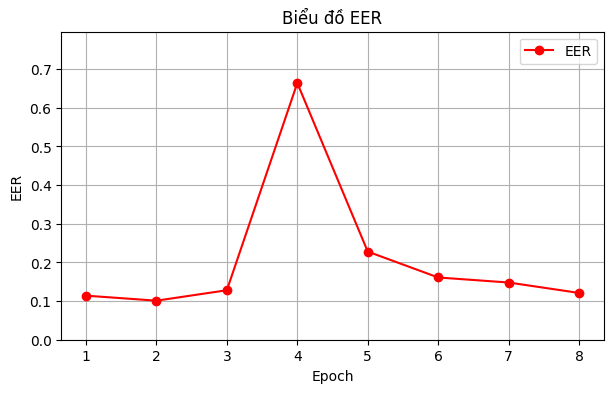

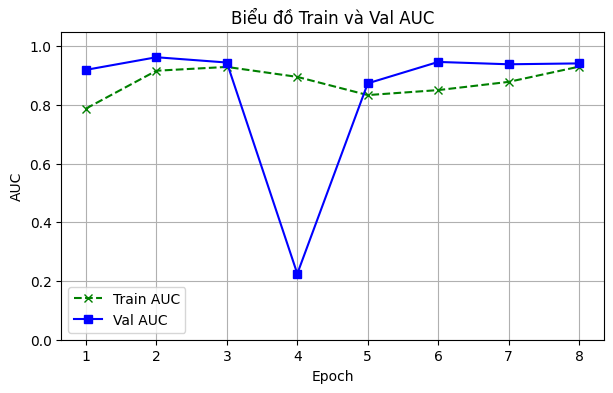

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8]
train_auc = [0.788, 0.917, 0.930, 0.896, 0.834, 0.851, 0.879, 0.931]
val_auc   = [0.920, 0.963, 0.945, 0.225, 0.874, 0.947, 0.939, 0.942]
eer       = [0.114, 0.101, 0.128, 0.664, 0.228, 0.161, 0.148, 0.121]

plt.figure(figsize=(7,4))
plt.plot(epochs, eer, marker='o', color='red', label='EER')
plt.xlabel('Epoch')
plt.ylabel('EER')
plt.title('Biểu đồ EER')
plt.grid(True)
plt.ylim(0, max(eer)*1.2)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, train_auc, marker='x', linestyle='--', color='green', label='Train AUC')
plt.plot(epochs, val_auc, marker='s', linestyle='-', color='blue', label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Biểu đồ Train và Val AUC')
plt.grid(True)
plt.ylim(0, 1.05)
plt.legend()
plt.show()


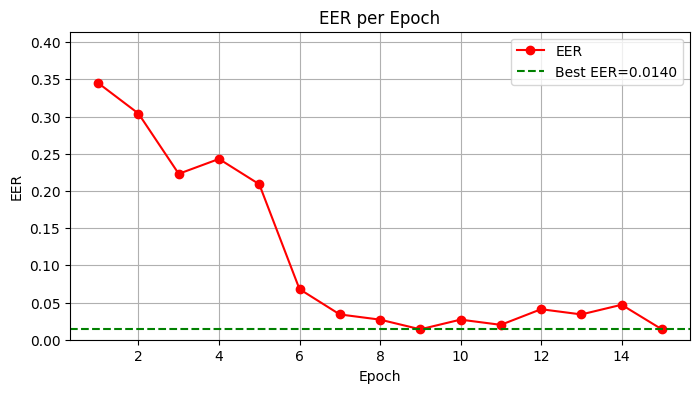

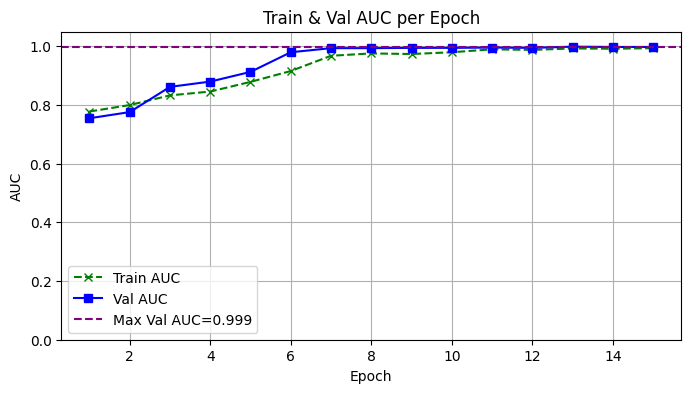

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

train_auc = [
    0.778, 0.800, 0.833, 0.846, 0.879, 0.916, 0.968, 0.976, 0.974, 0.980, 0.990, 0.988, 0.993, 0.992, 0.994
]

val_auc = [
    0.755, 0.776, 0.862, 0.880, 0.913, 0.980, 0.994, 0.994, 0.995, 0.995, 0.996, 0.995, 0.999, 0.998, 0.998
]

eer = [
    0.345, 0.304, 0.223, 0.243, 0.209, 0.068, 0.034, 0.027, 0.014, 0.027, 0.020, 0.041, 0.034, 0.047, 0.014
]

plt.figure(figsize=(7,4))
plt.plot(epochs, eer, marker='o', color='red', label='EER')
plt.xlabel('Epoch')
plt.ylabel('EER')
plt.title('EER per Epoch')
plt.grid(True)
plt.ylim(0, max(eer)*1.2)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, train_auc, marker='x', linestyle='--', color='green', label='Train AUC')
plt.plot(epochs, val_auc, marker='s', linestyle='-', color='blue', label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Train & Val AUC per Epoch')
plt.grid(True)
plt.ylim(0, 1.05)
plt.legend()
plt.show()


# Code Server


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2wF4eICfukoEn8U8JDRq9yfkVaD_51kDxLpQfgsUYZMFigTRu")


In [ ]:
!pip install fastapi uvicorn pyngrok soundfile torchaudio


In [ ]:
import io
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from fastapi import FastAPI, UploadFile, File, Query
from fastapi.middleware.cors import CORSMiddleware
from pyngrok import ngrok
import uvicorn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

def load_audio_from_bytes(audio_bytes: bytes) -> np.ndarray:
    wav, sr = sf.read(io.BytesIO(audio_bytes))
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    return wav.astype(np.float32)

SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256

MAX_LEN_AASIST = 256
CROP_SEC = 2.5
NUM_CROPS = 5
ENERGY_TH = 1e-4
TARGET_RMS = 0.08
TH_AASIST = 0.5

mel_extractor_aasist = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
    n_mels=N_MELS, power=2.0
).to(DEVICE)

class AASISTFrontend(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x.unsqueeze(1))

class SpectralAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)
    def forward(self, x):
        x = x.mean(dim=-1).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)

class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.MultiheadAttention(channels, 4, batch_first=True)
    def forward(self, x):
        x = x.mean(dim=2).transpose(1, 2)
        out, _ = self.attn(x, x, x)
        return out.mean(dim=1)

class AASIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = AASISTFrontend()
        self.spec_attn = SpectralAttention(128)
        self.temp_attn = TemporalAttention(128)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        x = self.frontend(x)
        spec = self.spec_attn(x)
        temp = self.temp_attn(x)
        return self.fc(torch.cat([spec, temp], dim=1)).squeeze(1)

aasist_model = AASIST().to(DEVICE)
aasist_model.load_state_dict(torch.load("/content/drive/MyDrive/Môn chuyên đề /model/AASIST/aasist_best.pt", map_location=DEVICE))
aasist_model.eval()

def normalize_soft(audio, target_rms=TARGET_RMS):
    rms = np.sqrt(np.mean(audio ** 2) + 1e-9)
    return audio * min(target_rms / rms, 3.0)

def split_crops_aasist(audio):
    crop_len = int(SR * CROP_SEC)
    if len(audio) <= crop_len:
        return [audio]
    starts = np.linspace(0, len(audio) - crop_len, NUM_CROPS).astype(int)
    crops = []
    for s in starts:
        seg = audio[s:s+crop_len]
        if np.mean(seg**2) > ENERGY_TH:
            crops.append(seg)
    return crops if crops else [audio[:crop_len]]

def predict_aasist(audio):
    audio = normalize_soft(audio)
    scores = []
    for seg in split_crops_aasist(audio):
        mel = torch.log(mel_extractor_aasist(torch.tensor(seg).to(DEVICE)) + 1e-9)
        mel = mel[:, :MAX_LEN_AASIST] if mel.shape[1] > MAX_LEN_AASIST else F.pad(mel, (0, MAX_LEN_AASIST - mel.shape[1]))
        with torch.no_grad():
            scores.append(torch.sigmoid(aasist_model(mel.unsqueeze(0))).item())
    score = float(np.max(scores)) if scores else 0.0
    return score, ("AI" if score >= TH_AASIST else "HUMAN")

MAX_LEN_CONF = 160
CROP_SEC = 2.5
NUM_CROPS = 5
TH_CONF = 0.5

mel_extractor_conf = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT,
    hop_length=HOP,
    n_mels=N_MELS,
    power=2.0
).to(DEVICE)

db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")

class ConvSubsampling(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv(x.unsqueeze(1))
        b, c, f, t = x.shape
        return x.view(b, c * f, t).transpose(1, 2)

class ConformerBlock(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.3):
        super().__init__()

        self.ff1 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
        )

        self.attn = nn.MultiheadAttention(
            dim, heads, dropout=dropout, batch_first=True
        )
        self.norm_attn = nn.LayerNorm(dim)

        self.conv = nn.Sequential(
            nn.Conv1d(dim, dim, 3, padding=1, groups=dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Conv1d(dim, dim, 1),
        )
        self.norm_conv = nn.LayerNorm(dim)

        self.ff2 = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
        )

        self.norm_out = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + 0.5 * self.ff1(x)
        attn, _ = self.attn(x, x, x)
        x = self.norm_attn(x + attn)
        conv = self.conv(x.transpose(1, 2)).transpose(1, 2)
        x = self.norm_conv(x + conv)
        x = x + 0.5 * self.ff2(x)
        return self.norm_out(x)

class AttentivePooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.att = nn.Linear(dim, 1)

    def forward(self, x):
        w = torch.softmax(self.att(x), dim=1)
        return (x * w).sum(dim=1)

ENC_DIM = 64 * (N_MELS // 4)

class AntiDeepfakeConformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.subsample = ConvSubsampling()
        self.encoder = nn.Sequential(
            ConformerBlock(ENC_DIM),
            ConformerBlock(ENC_DIM),
            ConformerBlock(ENC_DIM),
        )
        self.pool = AttentivePooling(ENC_DIM)
        self.fc = nn.Sequential(
            nn.Linear(ENC_DIM, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.subsample(x)
        x = self.encoder(x)
        x = self.pool(x)
        return self.fc(x).squeeze(1)

conformer_model = AntiDeepfakeConformer().to(DEVICE)
conformer_model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/Môn chuyên đề /model/Conformer/anti_ai_conformer_best.pt",
        map_location=DEVICE
    )
)
conformer_model.eval()

def split_crops_conf(audio):
    crop_len = int(SR * CROP_SEC)
    if len(audio) <= crop_len:
        return [audio]
    step = max((len(audio) - crop_len) // (NUM_CROPS - 1), 1)
    return [
        audio[i * step:i * step + crop_len]
        for i in range(NUM_CROPS)
        if len(audio[i * step:i * step + crop_len]) == crop_len
    ]

def predict_conformer(audio):
    audio = normalize_soft(audio)
    crops = split_crops_conf(audio)

    probs = []
    with torch.no_grad():
        for seg in crops:
            seg = torch.tensor(seg).to(DEVICE)
            mel = db_transform(mel_extractor_conf(seg))
            mel = mel[:, :MAX_LEN_CONF] if mel.shape[1] > MAX_LEN_CONF else F.pad(mel, (0, MAX_LEN_CONF - mel.shape[1]))
            prob = torch.sigmoid(conformer_model(mel.unsqueeze(0))).item()
            probs.append(prob)

    score = float(np.mean(probs)) if probs else 0.0
    return score, ("AI" if score >= TH_CONF else "HUMAN")


app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.post("/predict")
async def predict(
    file: UploadFile = File(...),
    model: str = Query("both", enum=["aasist", "conformer", "both"])
):
    audio = load_audio_from_bytes(await file.read())
    results = {}

    if model in ["aasist", "both"]:
        s, p = predict_aasist(audio)
        results["aasist"] = {"score": round(s, 4), "prediction": p}

    if model in ["conformer", "both"]:
        s, p = predict_conformer(audio)
        results["conformer"] = {"score": round(s, 4), "prediction": p}

    return {"filename": file.filename, "results": results}




DEVICE: cpu


In [ ]:
from threading import Thread
import uvicorn

public_url = ngrok.connect(8000)
print("PUBLIC URL:", public_url)

def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

Thread(target=run, daemon=True).start()


PUBLIC URL: NgrokTunnel: "https://b98badfc8530.ngrok-free.app" -> "http://localhost:8000"
